<a href="https://colab.research.google.com/github/ShiyuGong/NLP-APIs/blob/master/NLP_APIs_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

Sentiment analysis is a subfield of NLP and could be applied systematically to identify, extract, quantify, and study affective states and subjective information. 

In this colab notebook, I would use the following two Cloud resources to did sentiment analysis for Yelp Review dataset.

*   Google Cloud Natural Language API
*   Amazon Comprehend API




## Ingest

The Yelp review dataset collected from Kaggle contains 10K records of Yelp reviews. Each of them has the stars (1-5) and text review provided by customers.

data source: https://www.kaggle.com/omkarsabnis/yelp-reviews-dataset

In [0]:
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
df = pd.read_csv("/content/gdrive/My Drive/MachineLearning/NLP/yelp.csv")

In [0]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [0]:
df.info()

## EDA

In [0]:
df['business_id'].nunique()

4174

In [0]:
df["stars"].value_counts()/df.shape[0]

4    0.3526
5    0.3337
3    0.1461
2    0.0927
1    0.0749
Name: stars, dtype: float64

The above calculation gives us a first look on how the data spread. We can see that the rating tends to be relatively positive (68% of the ratings > = 4), which may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. 

#### Find reviews with low ratings

In [0]:
negative_reviews = df[df.stars == 1]
negative_reviews["text"].head()

23    U can go there n check the car out. If u wanna...
31    Disgusting!  Had a Groupon so my daughter and ...
35    I've eaten here many times, but none as bad as...
61    I have always been a fan of Burlington's deals...
64    Another night meeting friends here.  I have to...
Name: text, dtype: object

#### Find reviews with high ratings

In [0]:
negative_reviews = df[df.stars == 5]
negative_reviews["text"].head()

0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4    General Manager Scott Petello is a good egg!!!...
6    Drop what you're doing and drive here. After I...
Name: text, dtype: object

## Modeling

In the modeling part, we would focus on the reviews whose stars are 1 to see whether the sentiment analysis would provide the same negative results based on the text data.

In [0]:
rating1 = df[df['stars']==1]
rating1.shape

(749, 10)

### GCP- Natural Language API

Sentiment analysis attempts to determine the overall attitude (positive or negative) expressed within the text. Sentiment is represented by numerical score and magnitude values.

**Score of the sentiment ** ranges between -1.0 (negative) and 1.0 (positive) and corresponds to the overall emotional leaning of the text.

**Magnitude** indicates the overall strength of emotion (both positive and negative) within the given text, between 0.0 and +inf. Unlike score, magnitude is not normalized; each expression of emotion within the text (both positive and negative) contributes to the text's magnitude (so longer text blocks may have greater magnitudes).

In [0]:
import argparse

# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

In [0]:
import os;os.listdir("/content/gdrive/My Drive/awsml")

['config.txt', 'credentials.txt', 'cloudai-16c0b9420d70.json']

In [0]:
!ls -la /content/gdrive/My\ Drive/awsml

total 4
-rw------- 1 root root 2311 Mar  5 02:18 cloudai-16c0b9420d70.json
-rw------- 1 root root   28 Jan  9 04:01 config.txt
-rw------- 1 root root  113 Jan  9 04:26 credentials.txt


In [0]:
!export GOOGLE_APPLICATION_CREDENTIALS="/content/gdrive/My\ Drive/awsml/cloudai-16c0b9420d70.json"
!gcloud auth activate-service-account --key-file /content/gdrive/My\ Drive/awsml/cloudai-16c0b9420d70.json
!pip install --upgrade -q google-cloud-vision

Activated service account credentials for: [cloudai@cloudai-233600.iam.gserviceaccount.com]


In [0]:
# set up environment
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/awsml/cloudai-16c0b9420d70.json"

#### Example


In [0]:
def analyze(movie_review_filename):
    """Run a sentiment analysis request on text within a passed filename."""
    client = language.LanguageServiceClient()

    with open(movie_review_filename, 'r') as review_file:
        # Instantiates a plain text document.
        content = review_file.read()

    document = types.Document(
        content=content,
        type=enums.Document.Type.PLAIN_TEXT)
    annotations = client.analyze_sentiment(document=document)

    # Print the results
    print_result(annotations)

In [0]:
def print_result(annotations):
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude

    for index, sentence in enumerate(annotations.sentences):
        sentence_sentiment = sentence.sentiment.score
        print('Sentence {} has a sentiment score of {}'.format(
            index, sentence_sentiment))

    print('Overall Sentiment: score of {} with magnitude of {}'.format(
        score, magnitude))
    return 0

In [0]:
movie_review_filename = "/content/gdrive/My Drive/MachineLearning/NLP/bladerunner-pos.txt"

In [0]:
analyze(movie_review_filename)

Sentence 0 has a sentiment score of 0.8999999761581421
Sentence 1 has a sentiment score of 0.800000011920929
Sentence 2 has a sentiment score of 0.699999988079071
Sentence 3 has a sentiment score of 0.20000000298023224
Sentence 4 has a sentiment score of 0.5
Sentence 5 has a sentiment score of 0.0
Sentence 6 has a sentiment score of 0.30000001192092896
Sentence 7 has a sentiment score of 0.699999988079071
Sentence 8 has a sentiment score of 0.699999988079071
Sentence 9 has a sentiment score of 0.8999999761581421
Overall Sentiment: score of 0.6000000238418579 with magnitude of 6.199999809265137


The above example would indicate a review that was relatively positive (score of 0.6), and relatively emotional (magnitude of 6.2).

#### Yelp review

In [0]:
def create_sentiment_gcp(row):
    """Uses GCP Cloud NL to Create Sentiments on a DataFrame"""

    try:
      client = language.LanguageServiceClient()
      document = types.Document(
          content=row,
          type=enums.Document.Type.PLAIN_TEXT)
      sentiment = client.analyze_sentiment(document=document).document_sentiment
      sentiment_score = sentiment.score

    except Exception:
      print("Size exceeded:  Fail")
      return None
    return sentiment_score

def apply_sentiment_gcp(df, column="text"):
    """Uses Pandas Apply to Create Sentiment Analysis"""

    df['Sentiment'] = df[column].apply(create_sentiment_gcp)
    return df

In [0]:
rating1_senti_gcp = apply_sentiment_gcp(rating1)
rating1_senti_gcp.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,Sentiment
23,IJ0o6b8bJFAbG6MjGfBebQ,2010-09-05,Dx9sfFU6Zn0GYOckijom-g,1,U can go there n check the car out. If u wanna...,review,zRlQEDYd_HKp0VS3hnAffA,0,1,1,-0.3
31,vvA3fbps4F9nGlAEYKk_sA,2012-05-04,S9OVpXat8k5YwWCn6FAgXg,1,Disgusting! Had a Groupon so my daughter and ...,review,8AMn6644NmBf96xGO3w6OA,0,1,0,-0.6
35,o1GIYYZJjM6nM03fQs_uEQ,2011-11-30,ApKbwpYJdnhhgP4NbjQw2Q,1,"I've eaten here many times, but none as bad as...",review,iwUN95LIaEr75TZE_JC6bg,0,4,3,-0.2
61,l4vBbCL9QbGiwLuLKwD_bA,2011-11-22,DJVxOfj2Rw9zklC9tU3i1w,1,I have always been a fan of Burlington's deals...,review,EPROVap0M19Y6_4uf3eCmQ,0,0,0,0.0
64,CEswyP-9SsXRNLR9fFGKKw,2012-05-19,GXj4PNAi095-q9ynPYH3kg,1,Another night meeting friends here. I have to...,review,MjLAe48XNfYlTeFYca5gMw,0,1,2,-0.2


In [0]:
def deter_positive(value):
  if value > 0:return 'positive'
  elif value == 0: return 'neutral'
  elif value < 0: return 'negative'
  
rating1_senti_gcp['Sentiment_manually']=rating1_senti_gcp['Sentiment'].apply(lambda x:deter_positive(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
rating1_senti_gcp['Sentiment_manually'].value_counts()

negative    651
neutral      83
positive     15
Name: Sentiment_binary, dtype: int64

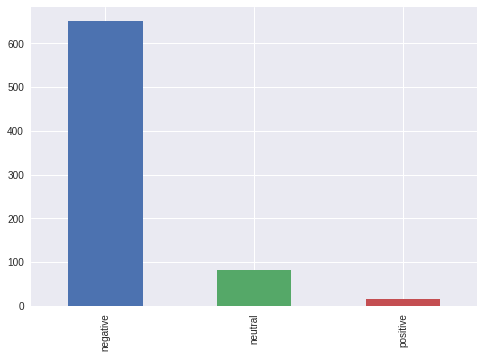

In [0]:
rating1_senti_gcp['Sentiment_manually'].value_counts().plot.bar()

### AWS Comprehend

Inspects text and returns an inference of the prevailing sentiment (POSITIVE, NEUTRAL, MIXED, or NEGATIVE)

#### Install boto3

In [0]:
!pip -q install boto3

#### Create API Config

In [0]:
!mkdir -p ~/.aws &&\
  cat /content/gdrive/My\ Drive/awsml/credentials.txt > ~/.aws/credentials

#### Test Comprehend API Call

In [0]:
import boto3
comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
text = "There is smoke in San Francisco and it makes me angry"
comprehend.detect_sentiment(Text=text, LanguageCode='en')

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '164',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 06 Mar 2019 00:52:17 GMT',
   'x-amzn-requestid': '17040402-3faa-11e9-89c1-1bb0e911a101'},
  'HTTPStatusCode': 200,
  'RequestId': '17040402-3faa-11e9-89c1-1bb0e911a101',
  'RetryAttempts': 0},
 'Sentiment': 'NEGATIVE',
 'SentimentScore': {'Mixed': 0.010819978080689907,
  'Negative': 0.9212133288383484,
  'Neutral': 0.06721948087215424,
  'Positive': 0.0007472822326235473}}

#### Creating an Apply function

In [0]:
def create_sentiment_aws(row):
    """Uses AWS Comprehend to Create Sentiments on a DataFrame"""

    try:
      comprehend = boto3.client(service_name='comprehend', region_name="us-east-2")
      payload = comprehend.detect_sentiment(Text=row, LanguageCode='en')  
      sentiment = payload['Sentiment']
    except Exception:
      print("Size exceeded:  Fail")
      return None
    return sentiment

def apply_sentiment_aws(df, column="text"):
    """Uses Pandas Apply to Create Sentiment Analysis"""

    df['Sentiment'] = df[column].apply(create_sentiment_aws)
    return df

In [0]:
rating1_senti_aws = apply_sentiment_aws(rating1)
rating1_senti_aws.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,Sentiment,Sentiment_binary
23,IJ0o6b8bJFAbG6MjGfBebQ,2010-09-05,Dx9sfFU6Zn0GYOckijom-g,1,U can go there n check the car out. If u wanna...,review,zRlQEDYd_HKp0VS3hnAffA,0,1,1,NEGATIVE,negative
31,vvA3fbps4F9nGlAEYKk_sA,2012-05-04,S9OVpXat8k5YwWCn6FAgXg,1,Disgusting! Had a Groupon so my daughter and ...,review,8AMn6644NmBf96xGO3w6OA,0,1,0,NEGATIVE,negative
35,o1GIYYZJjM6nM03fQs_uEQ,2011-11-30,ApKbwpYJdnhhgP4NbjQw2Q,1,"I've eaten here many times, but none as bad as...",review,iwUN95LIaEr75TZE_JC6bg,0,4,3,NEGATIVE,negative
61,l4vBbCL9QbGiwLuLKwD_bA,2011-11-22,DJVxOfj2Rw9zklC9tU3i1w,1,I have always been a fan of Burlington's deals...,review,EPROVap0M19Y6_4uf3eCmQ,0,0,0,NEGATIVE,neutral
64,CEswyP-9SsXRNLR9fFGKKw,2012-05-19,GXj4PNAi095-q9ynPYH3kg,1,Another night meeting friends here. I have to...,review,MjLAe48XNfYlTeFYca5gMw,0,1,2,NEUTRAL,negative


In [0]:
rating1_senti_aws['Sentiment'].value_counts()

NEGATIVE    608
POSITIVE     79
NEUTRAL      44
MIXED        18
Name: Sentiment, dtype: int64

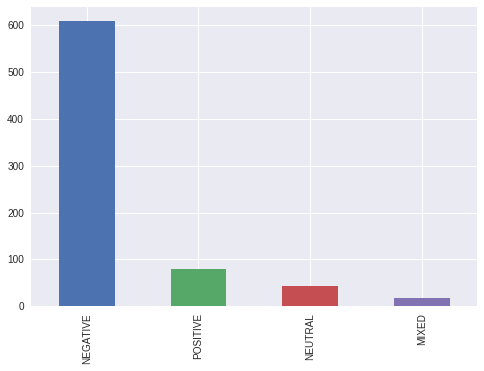

In [0]:
rating1_senti_aws['Sentiment'].value_counts().plot.bar()

# Conclusion

In this project, we practice how to use GCP- Natural Language API and AWS Comprehend API to conduct sentiment analysis for text reviews.

Based on the results, in terms of 749 records whose stars equal to 1,  86.9% of records are labelled as negative by GCP and 81.2% by AWS.

The differences between GCP and AWS sentiment analysis are as follows:


1.   AWS Comprehend provides an inference of the prevailing sentiment (POSITIVE, NEUTRAL, MIXED, or NEGATIVE) directly. GCP Natural Language analyzeSentiment only provides *score of the sentiment* ranging between -1.0 (negative) and 1.0 (positive). If we want to get sentiment, we need to set the boundary score of each sentiment manually.

2.  GCP Natural Language analyzeSentiment provides *magnitude* which indicates the overall strength of emotion within the given text, between 0.0 and +inf.






